# Utilities for data 

> This module handles all communication-related functionalities, including message passing, event handling, and notifications.

In [ ]:
#| default_exp data.utils

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastcore import *
from fastcore.utils import *

### Transforms

In [ ]:
#| export
import torch
from torchvision.transforms import v2
base_tf = v2.Compose([
    v2.ToPILImage(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

denormalize_tf = v2.Compose([
    v2.Normalize(mean=[0., 0., 0.], std=[1/0.5, 1/0.5, 1/0.5]),
    v2.Normalize(mean=[-0.5, -0.5, -0.5], std=[1., 1., 1.]),
])

In [ ]:
#| export
import torch
from torchvision.transforms import v2
lejepa_train_tf = v2.Compose(
    [
        v2.ToPILImage(),
        v2.RandomResizedCrop(42, scale=(0.8, 1.0)), 
        v2.RandomApply([v2.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
        v2.RandomGrayscale(p=0.2),
        v2.RandomApply([v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.1),
        v2.RandomHorizontalFlip(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)


lejepa_test_tf = v2.Compose(
            [
                v2.ToPILImage(),
                v2.Resize(42),
                v2.CenterCrop(42),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ]
        )

### Message creation as a transform

#### Using Graphics Primitives

In [ ]:
#| export
import cv2
import numpy as np
import torch
def get_graphics_primitives(img_np):
    img = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    pixels = img.reshape(-1, 3)
    colors = np.unique(pixels, axis=0)

    primitives = []
    background_color = np.array([0, 0, 0])  # assuming black background
    for color in colors:
        if np.all(color == background_color):
            continue

        mask = cv2.inRange(img, color, color)
        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            primitives.append((color, x, y, w, h))
            
    return primitives

In [ ]:
#| hide
import matplotlib.pyplot as plt
def plot_img_with_primitives(obs, primitives):
    
    fig, ax = plt.subplots(1)
    ax.imshow(obs)
    for primitive in primitives:
        color, x1, y1, w, h = primitive
        x2, y2 = x1 + w, y1 + h
        
        ax.add_patch(plt.Rectangle((x1, y1), w, h, edgecolor='r', facecolor='none', linewidth=2))
        rgb_color = (color[2]/255, color[1]/255, color[0]/255)
    # ax.plot((x1, x2), (y1, y2), '-r', linewidth=2)

In [ ]:
#| export
import cv2
import matplotlib.pyplot as plt
def show_grid(img, GRID = 7, CELL = 6):
    if not CELL:
        CELL = img.shape[0] // GRID
    
    vis = img.copy()
    vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    for i in range(1, GRID):
        cv2.line(vis, (i*CELL, 0), (i*CELL, 42), (255,255,255), 1)
        cv2.line(vis, (0, i*CELL), (42, i*CELL), (255,255,255), 1)
    plt.imshow(vis, interpolation="nearest")
    plt.axis("off")

    return vis


#### Parsing Color info only

In [ ]:
#| export

def get_cell_color(cell):
    np_to_tuple = lambda arr: tuple(int(x) for x in arr)
    pixels = cell.reshape(-1, 3)
    colors, counts = np.unique(pixels, axis=0, return_counts=True)
    
    if len(colors) == 1:
        if np_to_tuple(colors[0]) in [(0, 255, 0)]:
            return "G" #"Goal"
        elif np_to_tuple(colors[0]) in [(74, 65, 42)]:
            return "W" #"Wall"
        else:
            return "E" #"Empty"
        
    else:
        
        for color in colors:
            if np_to_tuple(color) in [(198, 0, 0), (28, 0, 0), (255, 0, 0)]:
                color = (255, 0, 0)
                return "R" #"RedAgent"
            elif np_to_tuple(color) in [(0, 0, 198), (0, 0, 255)]:
                color = (0, 0, 255)
                return "B" #"BlueAgent"
                
    

In [ ]:
# | export
def get_grid_chars(img, GRID=7, CELL=6): #cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cells = [[img[j*CELL:(j+1)*CELL, i*CELL:(i+1)*CELL]
              for i in range(GRID)]
              for j in range(GRID)
            ]
    
    grid = np.zeros((GRID,GRID), dtype=object)
    for r in range(GRID):
        for c in range(GRID):
            color = get_cell_color(cells[r][c])
            grid[r][c] = color
    return grid

In [ ]:
#| export
import torch.nn.functional as F
import torch
from einops import rearrange
def generate_msg(inp):
    img, agent_id, done, one_hot = inp
    if not done:
        grid = get_grid_chars(img)
    else:
        grid = np.array([['G' for _ in range(7)] for _ in range(7)])

    grid[3,3] = 'R' if '0' in agent_id else 'B' # Agent's own position

    mapping = {'E': 0, 'W': 1, 'G': 2, 'R': 3, 'B': 4}
    int_grid = np.array([[mapping[char] for char in row] for row in grid])
    grid = torch.from_numpy(int_grid).long()
    
    if not one_hot:
        return grid
    
    one_hot_msg = F.one_hot(grid, num_classes=5) # [7,7,5]
    one_hot_msg = rearrange(one_hot_msg, 'h w c -> c h w') # [5,7,7]
    
    return one_hot_msg.to(torch.float32)


In [ ]:
#| export
class MsgTransform(torch.nn.Module):
    def __init__(self, func=generate_msg):
        super().__init__()
        self.func = func
        
    def forward(self, inp):
        return self.func(inp)
    
from torchvision.transforms import v2
msg_tf = v2.Compose([
    MsgTransform()
])

In [ ]:
#| hide
data_path = './data_test/'
import os
data = np.load(os.path.join(data_path, 'rollout_6.npz'), allow_pickle=True)

In [ ]:
#| hide
img = data['agent_0_obs'][0]
done = data['agent_0_done'][0]

img.shape, done

((42, 42, 3), np.False_)

In [ ]:
#| hide
from torchvision.transforms import v2
tf = v2.Compose([
    MsgTransform()
])

import numpy as np
agent_id = "agent_0"
one_hot= True
msg = tf((img, agent_id, done, one_hot))
msg.shape

torch.Size([5, 7, 7])

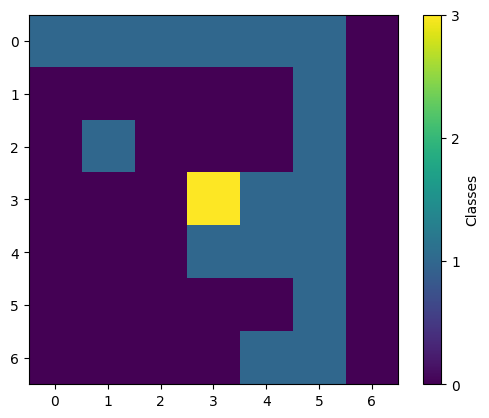

In [ ]:
#| hide
import matplotlib.pyplot as plt
plt.imshow(msg.permute(1, 2, 0).numpy().argmax(axis=-1), cmap='viridis')
plt.colorbar(ticks=[0,1,2,3,4], label='Classes')
plt.savefig('msg_visualization.png')
plt.show()

In [ ]:
#| export
def debug_channels(msg):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    titles = ['Empty', 'Wall', 'Goal', 'Red Agent', 'Blue Agent']

    for i in range(5):
        axes[i].imshow(msg[:, :, i].numpy(), cmap='gray')
        axes[i].set_title(titles[i])
    plt.savefig('msg_channels_visualization.png')
    plt.show()

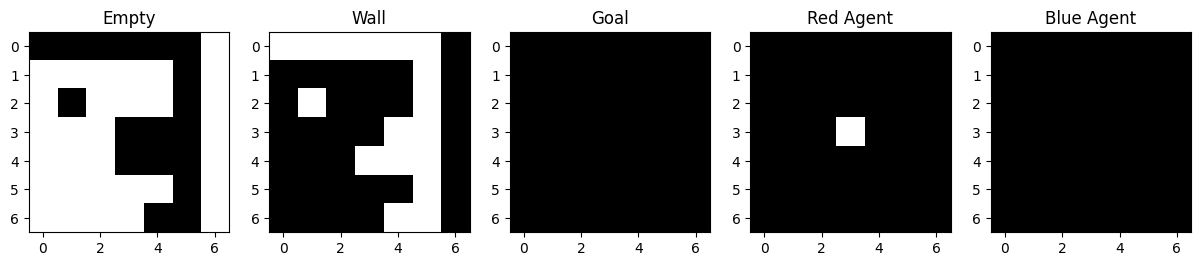

In [ ]:
#| hide
import matplotlib.pyplot as plt
msg = tf((img, agent_id, done, True))
debug_channels(msg.permute(1, 2, 0))


In [ ]:
#| export
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

def plot_grid(msg_tensor):
    grid_indices = msg_tensor.argmax(dim=-1).cpu().numpy()

    color_list = ['#2C2C2C', '#5D4037', '#4CAF50', '#FF0000', '#0000FF']
    cmap = colors.ListedColormap(color_list)
    
    bounds = [0, 1, 2, 3, 4, 5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(6, 6))
    img = plt.imshow(grid_indices, cmap=cmap, norm=norm)
    
    cbar = plt.colorbar(img, ticks=[0.5, 1.5, 2.5, 3.5, 4.5])
    cbar.ax.set_yticklabels(['Empty', 'Wall', 'Goal', 'Red', 'Blue'])
    
    plt.title("World Model: Decoded Message Grid")
    plt.grid(True, which='both', color='gray', linewidth=0.5, alpha=0.3)
    plt.show()



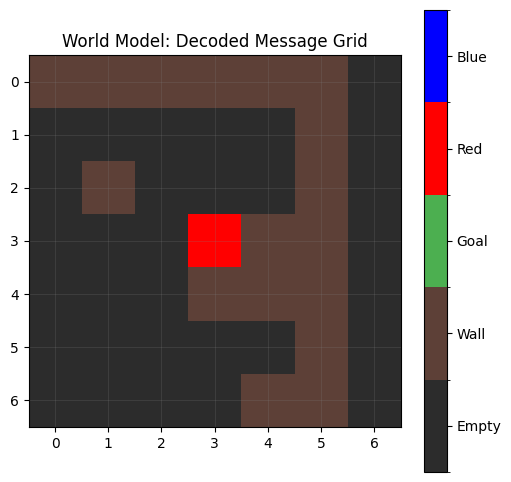

In [ ]:
#| hide
plot_grid(msg.permute(1, 2, 0))

### Done case

In [ ]:
#| hide
from torchvision.transforms import v2
tf = v2.Compose([
    MsgTransform()
])

import numpy as np
agent_id = "agent_0"
msg = tf((img, agent_id, True, True))
msg.shape

torch.Size([5, 7, 7])

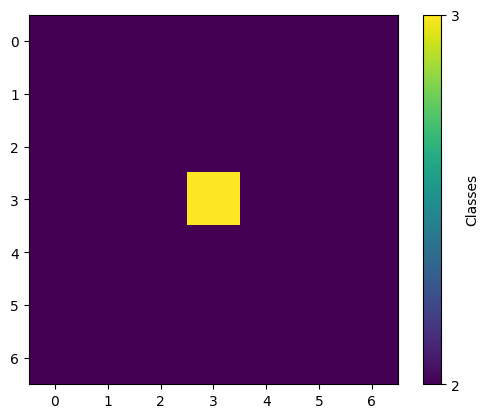

In [ ]:
#| hide
import matplotlib.pyplot as plt
plt.imshow(msg.permute(1, 2, 0).numpy().argmax(axis=-1), cmap='viridis')
plt.colorbar(ticks=[0,1,2,3,4], label='Classes')
plt.show()

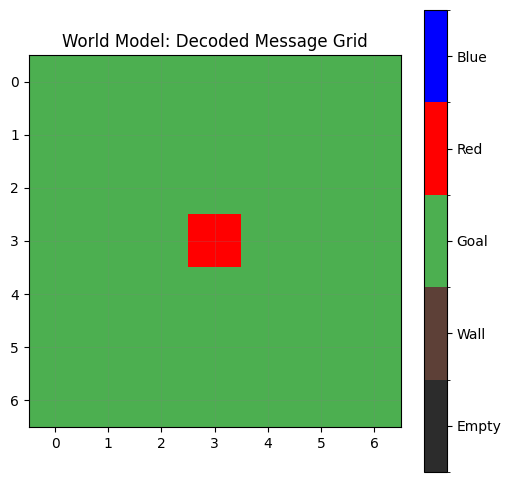

In [ ]:
#| hide
plot_grid(msg.permute(1, 2, 0))

### Visualizing Message Channels

In [ ]:
#| export
def plot_grid(img_tensor, msg_tensor):
    grid_indices = msg_tensor.argmax(dim=-1).cpu().numpy()
    
    color_list = ['#2C2C2C', '#5D4037', '#4CAF50', '#FF0000', '#0000FF']
    cmap = colors.ListedColormap(color_list)
    
    bounds = [0, 1, 2, 3, 4, 5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # plot image and grid side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(img_tensor)
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    img = axs[1].imshow(grid_indices, cmap=cmap, norm=norm)
    axs[1].set_title("Decoded Message Grid")
    axs[1].axis('off')
    
    cbar = fig.colorbar(img, ax=axs[1], ticks=[0.5, 1.5, 2.5, 3.5, 4.5])
    cbar.ax.set_yticklabels(['Empty', 'Wall', 'Goal', 'Red', 'Blue'])
    
    plt.show()

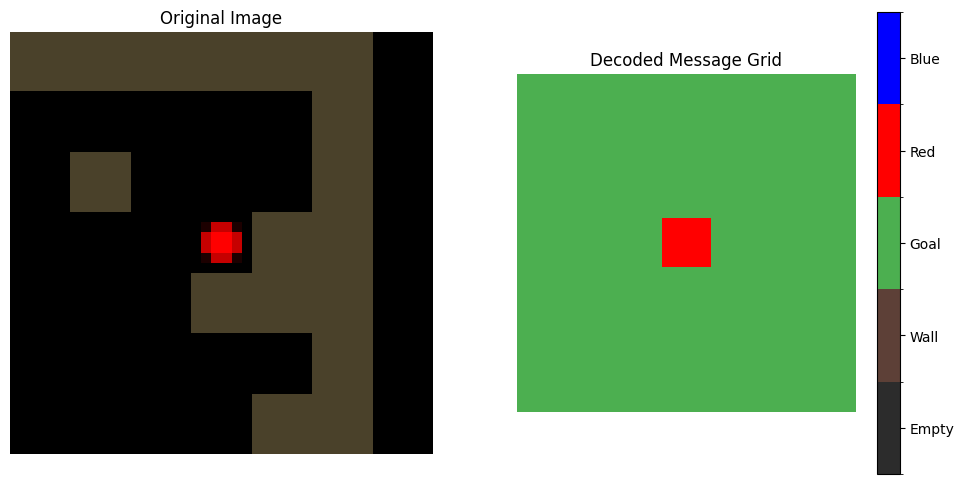

In [ ]:
#| hide
plot_grid(img, msg.permute(1, 2, 0))

### Data Loading

In [ ]:
#| export
import os
def get_data_path():
    paths = {
        "kaggle": "/kaggle/input/marlgridv3/MarlGridV3/",
        "puhti": "/scratch/project_2009050/datasets/MarlGridV3/",
        "mahti": "/scratch/project_2009050/datasets/MarlGridV3/",
        "triton": "/scratch/work/sehadn1/MarlGridV3/",
        "local": "/home/ahmed//Ahmed-home/1- Projects/Research/Journal 2/Code/mawm/nbs/data_test/",
        "local_full": "/home/ahmed//Ahmed-home/Downloads/data/MarlGridV3/"
    }

    for hostname, path in paths.items():
        if os.path.exists(path):
            print(f"Data path found for hostname: {hostname}")
            return path
    raise FileNotFoundError("No valid data path found for this hostname.")


In [ ]:
#| export
import torch

from mawm.data.loaders import MarlGridDataset
def init_data_single(cfg):
    cfg.data.data_dir = get_data_path()

    train_ds = MarlGridDataset(
        cfg= cfg,
        train= True,
        transform= base_tf,
        msg_tf= msg_tf
    )

    data_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=cfg.data.batch_size,
        drop_last=cfg.data.loader.drop_last,
        shuffle= True,
    )
    sampler = None


    return data_loader, sampler


/home/ahmed/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#| hide
from omegaconf import OmegaConf


In [ ]:
#| hide
cfg = OmegaConf.load("../cfgs/MPCJepa/mpc.yaml")
cfg.data.data_dir = "./data_test"

In [ ]:
# #| hide
# dl, test_dl = init_data(cfg)

In [ ]:
# #| hide
# batch = next(iter(dl))
# sample = batch['agent_0']['obs'][0, 0, :, :, :]

In [ ]:
# #| hide
# batch['agent_0']['obs'].shape

torch.Size([8, 5, 3, 42, 42])

In [ ]:
# #| hide
# sample.shape, sample.dtype, sample.min(), sample.max()

(torch.Size([3, 42, 42]), torch.float32, tensor(-1.), tensor(1.))

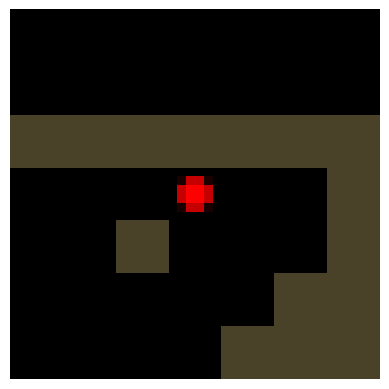

In [ ]:
# #| hide
# import matplotlib.pyplot as plt
# denmormalize = lambda x: x * 0.5 + 0.5
# img = denmormalize(sample)
# plt.imshow(torch.einsum('chw->hwc', img).numpy())
# plt.axis('off')
# plt.show()

In [ ]:
# #| hide
# batch['agent_0']['msg'][0, 0, :, :, :].shape

torch.Size([7, 7, 5])

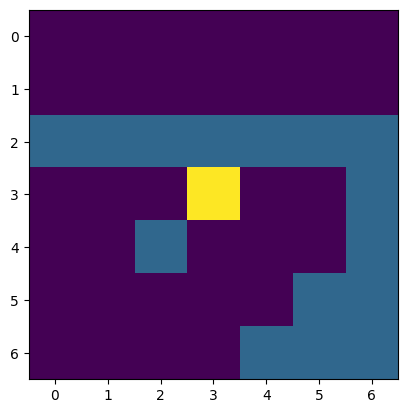

In [ ]:
# #| hide
# import matplotlib.pyplot as plt
# plt.imshow(batch['agent_0']['msg'][0, 0, :, :, :].numpy().argmax(axis=-1))
# plt.show()

### Various utils

In [ ]:
#| export
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import einops
def show_batch(dl, denormalize_tf, save_to="./batch.png"):
    dataiter = iter(dl)
    data = next(dataiter)
    images = data['agent_0']['obs']

    if images.ndim == 5:
        images = einops.rearrange(images, 'b s c h w -> (b s) c h w')
        print(images.shape)

    print(f"Max pixel value: {images.max().item()}")
    print(f"Mean pixel value: {images.mean().item()}")
    images = denormalize_tf(images) if denormalize_tf is not None else images
    print(f"After denormalization:")
    print("+"*20)
    print(f"Max pixel value: {images.max().item()}")
    print(f"Mean pixel value: {images.mean().item()}")
    images = torch.clamp(images, 0, 1)

    grid_img = torchvision.utils.make_grid(images, nrow=8) # nrow controls how many images per row
    np_grid = torch.einsum('chw->hwc', grid_img).numpy()


    plt.figure(figsize=(15, 10))
    plt.imshow(np_grid)
    plt.axis('off')
    plt.savefig(save_to, bbox_inches='tight')
    plt.savefig("pdf.pdf", bbox_inches='tight')
    plt.show()

torch.Size([40, 3, 42, 42])
Max pixel value: 1.0
Mean pixel value: -0.8795627355575562
After denormalization:
++++++++++++++++++++
Max pixel value: 1.0
Mean pixel value: 0.060218606144189835


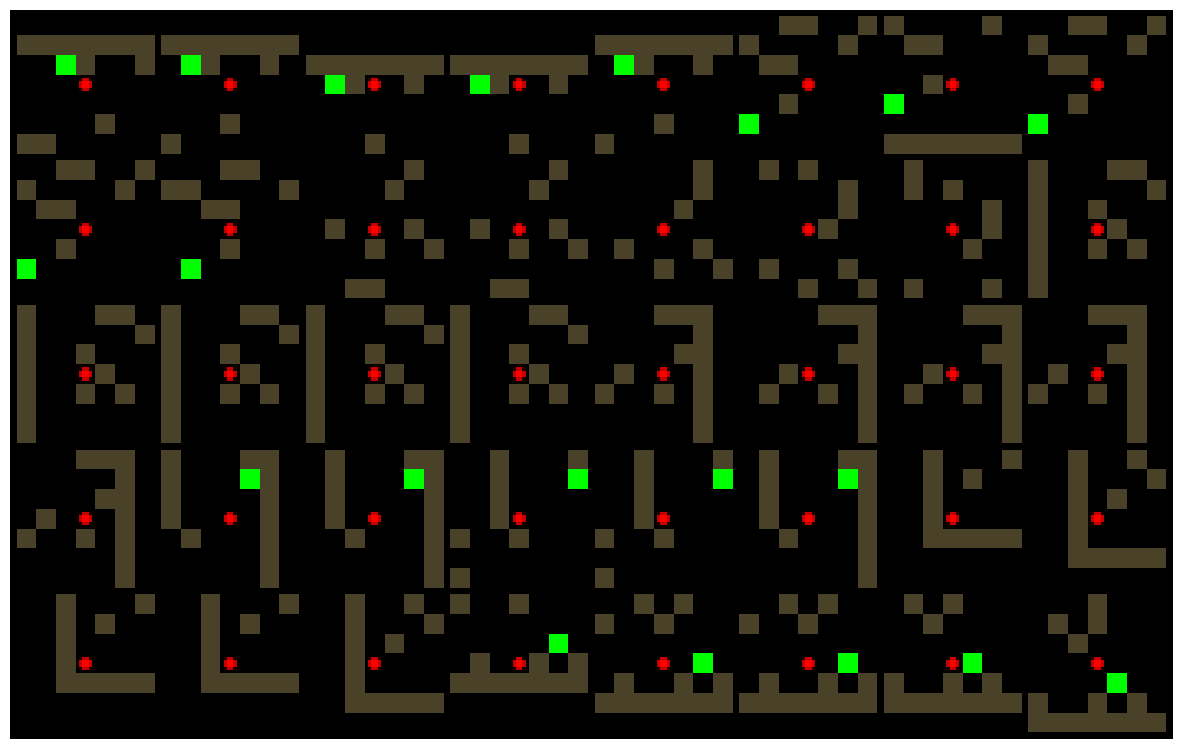

In [ ]:
# #| hide
# show_batch(dl, denormalize_tf, save_to="../batch.png")

### Distributed Dataloaders

In [ ]:
#| export
import torch
def init_data_dist(
        cfg,
        train= True,
        collator=torch.utils.data.default_collate,
):
    cfg.data.data_dir = get_data_path()
    train_ds = MarlGridDataset(
        cfg= cfg,
        train= train,
        transform= base_tf,
        msg_tf= msg_tf
    )

    dist_sampler = torch.utils.data.distributed.DistributedSampler(train_ds)

    data_loader = torch.utils.data.DataLoader(
        train_ds,
        collate_fn=collator,
        sampler=dist_sampler,
        batch_size=cfg.data.batch_size,
        drop_last=cfg.data.loader.drop_last,
        pin_memory=cfg.data.loader.pin_memory,
        num_workers=cfg.data.loader.num_workers,
        persistent_workers=(cfg.data.loader.num_workers > 0) and cfg.data.loader.persistent_workers,
    )

    # logger.info("VideoDataset unsupervised data loader created")

    return data_loader, dist_sampler



In [ ]:
#| export
def init_data(cfg, distributed= False):
    if distributed:
        return init_data_dist(cfg)
    else:
        return init_data_single(cfg)


In [ ]:
# #| hide
# from omegaconf import OmegaConf
# cfg = OmegaConf.load("../cfgs/findgoal/mawm/ablations/datasize/mawm_ds_200k.yaml")
# dl, test_dl = init_data(cfg)

Data path found for hostname: local
Limiting dataset to 200000 samples.
Limiting dataset to 200000 samples.


In [ ]:
# #| hide
# batch = next(iter(dl))
# batch.keys()

dict_keys(['agent_0', 'agent_1'])

In [ ]:
# #| hide
# batch['agent_0']['obs'][0, 0, :, :, :].shape

torch.Size([3, 42, 42])

torch.Size([400, 3, 42, 42])
Max pixel value: 1.0
Mean pixel value: -0.8198191523551941
After denormalization:
++++++++++++++++++++
Max pixel value: 1.0
Mean pixel value: 0.09009043872356415


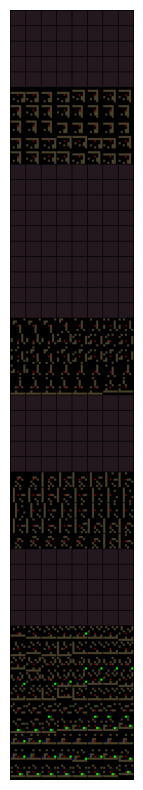

In [ ]:
# #| hide
# show_batch(dl, denormalize_tf)

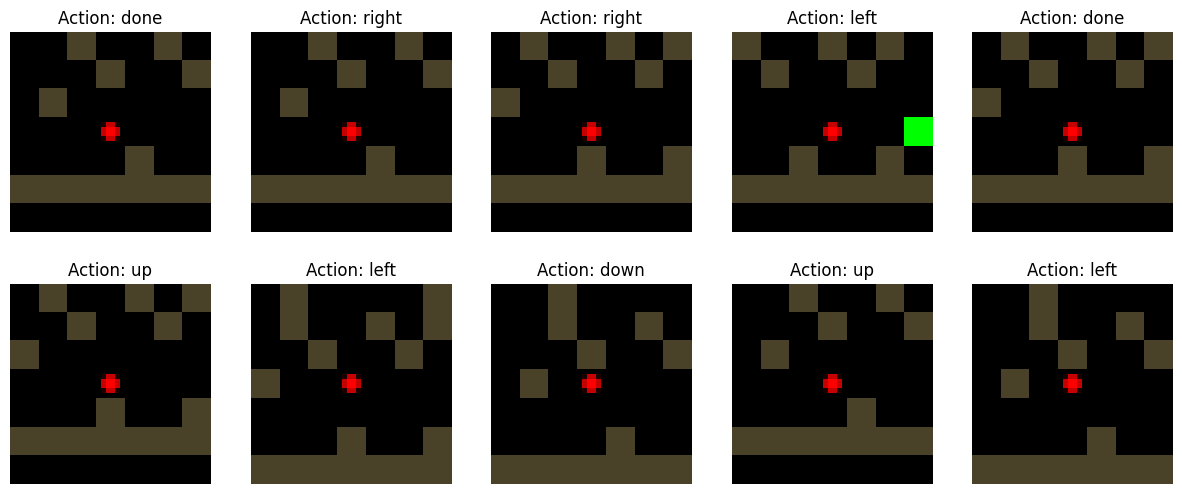

In [ ]:
# #| hide
# action_mapping = {
#     0: "right",
#     1: "down",
#     2: "left",
#     3: "up",
#     4: "done"
# }

# import matplotlib.pyplot as plt
# fig, axs = plt.subplots(2, 5, figsize=(15, 6))
# for i in range(10):
#     obs = batch['agent_0']['obs'][0, i, :, :, :]
#     action = batch['agent_0']['act'][0, i, :]
#     action_str = action.argmax().item()
#     obs = denormalize_tf(obs)
#     obs = torch.clamp(obs, 0, 1)
#     ax = axs[i // 5, i % 5]
#     ax.imshow(torch.einsum('chw->hwc', obs).numpy())
#     ax.set_title(f"Action: {action_mapping[action_str]}")
#     ax.axis('off')
# plt.savefig('agent0_actions.png', bbox_inches='tight')
# plt.show()


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()